<a href="https://colab.research.google.com/github/AstridZhao/Spring2023DeepLearning/blob/main/deep_learning_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows you how to model sequential data with Long Short-Term Memory (LSTM) model to predict sentiment scores.



# Data acquisition

In [2]:
# import essential packages

from keras.utils import to_categorical, pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
!pip install pytreebank
import pytreebank
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Load the dataset from disk
dataset = pytreebank.load_sst("/path/to/sentiment/")

train_data = dataset['train']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Preparation

In [3]:
# Example sentence data and sentiment ratings
sentences = []
sentiment_ratings = []

for tree in train_data:
  datapoint = tree.to_labeled_lines()[0]
  sentiment_ratings.append(datapoint[0])
  sentences.append(datapoint[1])

In [4]:
# Tokenize sentences and convert sentiment ratings to categorical labels
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
word_index = tokenizer.word_index
max_sequence_length = max([len(seq) for seq in sequences])
data = pad_sequences(sequences, maxlen=max_sequence_length)
labels = to_categorical(sentiment_ratings)

In [5]:
# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=0)
test_data, val_data, test_labels, val_labels = train_test_split(test_data, test_labels, test_size=0.2, random_state=0)

# Training the model
Creating the model and the data, and training and evaluating the model:

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

embedding_dim = 300

# Define the model
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim, input_length=max_sequence_length))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='tanh', recurrent_activation='sigmoid', dropout=0.2, recurrent_dropout=0, unroll=False, use_bias=True))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 49, 300)           4600200   
                                                                 
 dropout_1 (Dropout)         (None, 49, 300)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                93440     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 4,693,965
Trainable params: 4,693,965
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile and train the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

model.fit(train_data, train_labels, validation_data = (val_data, val_labels), epochs=1000, batch_size=32, callbacks=[es])

Epoch 1/1000
214/214 [==============================] - 42s 168ms/step - loss: 1.5349 - accuracy: 0.3072 - val_loss: 1.4321 - val_accuracy: 0.3977
Epoch 2/1000
 88/214 [===========>..................] - ETA: 18s - loss: 1.2373 - accuracy: 0.4759

# Simple evaluation

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

43/43 [==============================] - 0s 11ms/step - loss: 1.4631 - accuracy: 0.3958
Test Accuracy: 39.58%


43/43 [==============================] - 1s 13ms/step


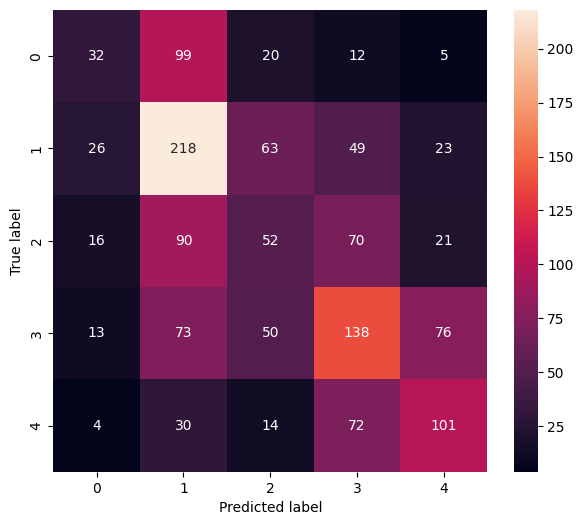

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# calculate the confusion matrix
preds = model.predict(test_data)
conf = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(preds, axis=1))

# plot the confusion matrix as a heatmap
plt.figure(figsize=(7,6))
sns.heatmap(conf, annot=True, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()